# Imports and set up

In [ ]:
import pandas as pd
import math
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from xml.etree.ElementTree import iterparse
import re
import os
import csv
import json

drive.mount('/content/drive')
plt.style.use('ggplot')
%matplotlib inline

Mounted at /content/drive


In [ ]:
_REPROCESS_ = False

_HEALTH_ROOT_ = '/content/drive/My Drive/Health Data/'
if not os.path.exists(_HEALTH_ROOT_):
  raise Exception("Health folder not found")

_APPLE_ROOT_ = os.path.join(_HEALTH_ROOT_, 'Apple')
if not os.path.exists(_APPLE_ROOT_):
  raise Exception("APPLE folder not found")

_FITBIT_ROOT_ = os.path.join(_HEALTH_ROOT_, 'Fitbit')
if not os.path.exists(_FITBIT_ROOT_):
  raise Exception("FITBIT folder not found")

_PARSED_ROOT_ = os.path.join(_HEALTH_ROOT_, 'Parsed')
if not os.path.exists(_PARSED_ROOT_):
  raise Exception("Destination ('Parsed') folder not found")

In [ ]:
def find_latest_path(path: str) -> str:
  if not os.path.exists(path):
    print("The file does not exist")
    return None
  if not os.path.isdir(path):
    print("The path is not a directory")
    return None

  last_time = 10000000 # sometime in 1970
  latest_path = None
  for path_name in os.listdir(path):
    full_path = os.path.join(path, path_name)
    ctime = os.path.getmtime(full_path)
    if ctime > last_time:
      last_time = ctime
      latest_path = full_path
  return latest_path

# Parse Apple data

In [ ]:
latest_apple_path = find_latest_path(_APPLE_ROOT_)
if latest_apple_path is None:
  print("No Apple data found")

## Generic HKQuantity values in export.html

In [ ]:
file_path = os.path.join(latest_apple_path, 'export.xml')
if not os.path.exists(file_path):
  raise Exception(f"No export.xml file found in the Apple folder {latest_apple_path}")

output_path = os.path.join(_PARSED_ROOT_, 'apple_export.csv')
print(f"Output path: {output_path}")

Output path: /content/drive/My Drive/Health Data/Parsed/apple_export.csv


In [ ]:
if _REPROCESS_:
  with open(output_path, 'w') as f_out:
    writer = csv.writer(f_out)
    columns = ["startDate", "endDate", "type", "unit", "value", "source"]
    writer.writerow(columns)

    with open(file_path, 'r') as f_in:
      # i = 0
      for _, elem in iterparse(f_in):
        # if i>1000:
        #   break
        # i += 1
        if elem.tag == 'Record':
          row = elem.attrib
          try:
            # print(f'writing: {row}')
            writer.writerow(
                [row.get(u'startDate', ''),
                row.get(u'endDate', ''),
                row.get(u'type', ''),
                row.get(u'unit', ''),
                row.get(u'value', ''),
                row.get(u'sourceName', '')]
            )
          except KeyError as e:
            print(f"KeyError: {e}")

## Clinical Records

In [ ]:
clinical_records_path = os.path.join(latest_apple_path, 'clinical-records')
if not os.path.exists(clinical_records_path):
  raise Exception("No clinical records found")

labs_output_path = os.path.join(_PARSED_ROOT_, 'labs_export.csv')
print(f"Output path: {labs_output_path}")

Output path: /content/drive/My Drive/Health Data/Parsed/labs_export.csv


In [ ]:
def process_lab_observation(data: dict) -> dict:
  obs_date = ''
  obs_name = ''
  obs_value = ''
  obs_unit = ''
  low_ref = ''
  high_ref = ''
  code = ''

  obs_date = data.get('effectiveDateTime', '')

  # check if it's a lab or a vital
  category = data.get('category', {}).get('coding', [])
  if len(category) > 0:
    category = category[0].get('code')

  if category == 'laboratory':
    # get rid of any "valueString" observations
    if 'valueString' in data:
      return {}
    # get the name and code
    obs_name = data.get('code', {}).get('text', '')
    obs_code = data.get('code', {}).get('coding', [])
    if len(obs_code) > 0:
      code = obs_code[0].get('code', '')
      if obs_name == '':
        obs_name = obs_code[0].get('display', '')

    # get the value, unit and reference range
    obs_value = data.get('valueQuantity', {}).get('value', '')
    if obs_value == '':
      return {}
    obs_unit = data.get('valueQuantity', {}).get('unit', '')

    reference = data.get('referenceRange', [])
    if len(reference) > 0:
      low_ref = reference[0].get('low', {}).get('value', '')
      high_ref = reference[0].get('high', {}).get('value', '')
  elif category == 'vital-signs':
    # skip vital-signs
    return {}
  else:
    print(f"not processing: {data} from {file_path}")
    return {}

  return {'date': obs_date,
          'lab': obs_name,
          'value': obs_value,
          'unit': obs_unit,
          'low_ref': low_ref,
          'high_ref': high_ref,
          'code': code}

In [ ]:
df_labs = pd.DataFrame(columns=['date',
                                'lab',
                                'value',
                                'unit',
                                'low_ref',
                                'high_ref',
                                'code'])
df_allergies = pd.DataFrame(columns=['date',
                                     'substance',
                                     'code'])
df_medications = pd.DataFrame(columns=['date',
                                       'medication',
                                       'code'])
df_immunizations = pd.DataFrame(columns=['date',
                                        'immunization',
                                        'code'])
df_conditions = pd.DataFrame(columns=['date',
                                      'condition',
                                      'code'])

n_observations = 0
n_diagnostic_reports = 0
n_procedure = 0
for file_path in os.listdir(clinical_records_path):
  if not file_path.endswith('.json'):
    continue
  with open(os.path.join(clinical_records_path, file_path),'r') as f_in:
    data = json.load(f_in)

  if data.get('resourceType') == 'MedicationStatement':
    med_date = ''
    medication = ''
    code = ''
    if 'contained' in data:
      for item in data.get('contained'):
        if not type(item) == dict:
          raise Exception(f"Unrecognized format for MedicationStatement['contained']: {data.get('contained')}")
        medication = item['code']['text']
        if 'coding' in item['code']:
          code = item['code']['coding'][0]['code']

    if 'medicationCodeableConcept' in data:
      medication = data['medicationCodeableConcept']['text']
      code = data['medicationCodeableConcept']['coding'][0]['code']

    if 'effectivePeriod' in data:
      if 'start' in data['effectivePeriod']:
        med_date = data['effectivePeriod']['start']
      if 'end' in data['effectivePeriod']:
        med_date = data['effectivePeriod']['end']

    df_medications = pd.concat([df_medications,
                                pd.DataFrame({'date': med_date,
                                              'medication': medication,
                                              'code': code},
                                            index=[0])]).reset_index(drop=True)

  elif data.get('resourceType') == 'Immunization':
    vac_date = ''
    immunization = ''
    code = ''
    if 'date' in data:
      vac_date = data['date']
    if 'vaccineCode' in data:
      immunization = data['vaccineCode']['coding'][0]['display']
      code = data['vaccineCode']['coding'][0]['code']
    df_immunizations = pd.concat([df_immunizations,
                                  pd.DataFrame({'date': vac_date,
                                                'immunization': immunization,
                                                'code': code},
                                               index=[0])]).reset_index(drop=True)

  elif data.get('resourceType') == 'MedicationOrder':
    med_date = ''
    medication = ''
    code = ''
    if 'dateWritten' in data:
      med_date = data.get('dateWritten')
    if 'contained' in data:
      for item in data.get('contained'):
        if not type(item) == dict:
          raise Exception(f"Unrecognized format for medicationOrder['contained']: {data.get('contained')}")
        medication = item['code']['text']
        code = item['code']['coding'][0]['code']
    df_medications = pd.concat([df_medications,
                                pd.DataFrame({'date': med_date,
                                              'medication': medication,
                                              'code': code},
                                              index=[0])]).reset_index(drop=True)

  elif data.get('resourceType') == 'AllergyIntolerance':
    allergy_date = ''
    substance = ''
    code = ''
    if 'recordedDate' in data:
      allergy_date = data['recordedDate']
    if 'substance' in data:
      substance = data['substance']['text']
      if 'coding' in data['substance']:
        code = data['substance']['coding'][0]['code']
    df_allergies = pd.concat([df_allergies,
                              pd.DataFrame({'date': allergy_date,
                                            'substance': substance,
                                            'code': code},
                                           index=[0])]).reset_index(drop=True)

  elif data.get('resourceType') == 'Condition':
    cond_date = ''
    condition = ''
    code = ''
    if 'onsetDateTime' in data:
      cond_date = data['onsetDateTime']
    if 'code' in data:
      if 'coding' in data['code']:
        condition = data['code']['coding'][0]['display']
        code = data['code']['coding'][0]['code']
      else:
        condition = data['code']['text']
    df_conditions = pd.concat([df_conditions,
                               pd.DataFrame({'date': cond_date,
                                             'condition': condition,
                                             'code': code},
                                            index=[0])]).reset_index(drop=True)

  elif data.get('resourceType') == 'Patient':
    pass
  elif data.get('resourceType') == 'Procedure':
    pass

  elif data.get('resourceType') == 'Observation':
    lab = process_lab_observation(data)
    if len(lab) > 0:
      df_labs = pd.concat([df_labs,
                           pd.DataFrame(lab, index=[0])]).reset_index(drop=True)

  elif data.get('resourceType') == 'DiagnosticReport':
    report = data.get('contained', [])
    for item in report:
      lab = process_lab_observation(item)
      if len(lab) > 0:
        df_labs = pd.concat([df_labs,
                             pd.DataFrame(lab, index=[0])]).reset_index(drop=True)
  else:
    print(f"not processing: {file_path} with {data.get('resourceType')}")

df_labs['date'] = pd.to_datetime(df_labs['date'], format='mixed')
df_labs['lab'] = df_labs['lab'].str.lower()
df_labs = df_labs.drop_duplicates(subset=['date', 'lab', 'value'])
df_labs = df_labs.sort_values(by=['date', 'lab']).reset_index(drop=True)

In [ ]:
# sandardize lab names
lab_name_patterns = [
    (r'^(basophils|baso|% basophils)(?!.*abs.*)', 'basophils'),
    (r'^(eosinophils|eos|% eosinophils)(?!.*abs.*)', 'eosinophils'),
    (r'^(lymphocytes|lymphs|% lymphocytes)(?!.*abs.*)', 'lymphocytes'),
    (r'^(monocytes|% monocytes)(?!.*abs.*)', 'monocytes'),
    (r'^(neutrophils|%.*neutroph.*)(?!.*abs.*)', 'neutrophils'),
    (r'^(immature granulocytes|%.*immat.*)(?!.*abs.*)', 'immature granulocytes'),
    (r'(^(abs.*)+baso.*|^baso.*abs.*)', 'absolute basophils'),
    (r'(^(abs.*)+eos.*|^eos.*abs.*)', 'absolute eosinophils'),
    (r'(^(abs.*)+neutro.*|^neutro.*abs.*)', 'absolute neutrophils'),
    (r'(^(abs.*)+monocy.*|^monocy.*abs.*)', 'absolute monocytes'),
    (r'(^(abs.*)+lymph.*|^lymph.*abs.*)', 'absolute lymphocites'),
    (r'(^(abs.*)+immat.*|^immat.*abs.*)', 'absolute immature granulocytes'),
    (r'^albumin[^/]', 'albumin'),
    (r'^a/g.*', 'albumin/globulin ratio'),
    (r'^alkaline phosphatase.*', 'alkaline phosphatase'),
    (r'^alt.*', 'alt'),
    (r'^ast.*', 'ast'),
    (r'.*bilirubin.*', 'bilirubin'),
    (r'.*urea nit.*', 'bun'),
    (r'^calcium.*', 'calcium'),
    (r'.*dioxide.*', 'carbon dioxide'),
    (r'^chloride.*', 'chloride'),
    (r'^creatinine.*', 'creatinine'),
    (r'^cholesterol.*', 'cholesterol'),
    (r'.*cortisol.*', 'cortisol'),
    (r'.*creatine kin.*', 'creatine kinase'),
    (r'^globulin.*', 'globulin'),
    (r'^glucose.*', 'glucose'),
    (r'^hdl.*(c\Z|chol.*)', 'hdl'),
    (r'^ldl.*(c\Z|chol.*)', 'ldl'),
    (r'^hematocrit.*', 'hematocrit'),
    (r'^hemoglobin,.*', 'hemoglobin'),
    (r'^hemoglobin a.*', 'hba1c'),
    (r'^magnesium.*', 'magnesium'),
    (r'^mch.*', 'mch'),
    (r'^mchc.*', 'mchc'),
    (r'^mcv.*', 'mcv'),
    (r'^mpv.*', 'mpv'),
    (r'^rdw.*', 'rdw'),
    (r'^nhdlc', 'non hdl cholesterol'),
    (r'.*platelet.*', 'platelets'),
    (r'^potassium.*', 'potassium'),
    (r'.*protein.*tot.*', 'protein, total'),
    (r'^rbc.*', 'red blood cell count'),
    (r'^sodium.*', 'sodium'),
    (r'^testosterone.*', 'testosterone'),
    (r'^triglyc.*', 'triglycerides'),
    (r'^vitamin d.*', 'vitamin d'),
    (r'^wbc.*', 'white blood cell count')
]

unit_patterns = [
    (r'^notyet', '')
]

def standardize_strings(input_str: str, patterns: list) -> str:
  for pattern, replacement in patterns:
    if re.search(pattern, input_str, re.IGNORECASE):
      return replacement
  return input_str

def standardize_names(lab_name:str) -> str:
  return standardize_strings(lab_name, lab_name_patterns)

def standardize_units(unit:str) -> str:
  return standardize_strings(unit, unit_patterns)

df = df_labs.copy().reset_index(drop=True)
df['lab'] = df['lab'].apply(standardize_names)
df['unit'] = df['unit'].apply(standardize_units)
df = df.sort_values(by=['lab']).reset_index(drop=True)
df

,date,lab,value,unit,low_ref,high_ref,code
0,2018-01-05 04:59:00+00:00,% nrbc,0.0,%,0,0,58413-6
1,2022-07-10 13:02:04-04:00,% saturation,28.0,% (calc),20.0,48.0,2502-3
2,2018-01-05 04:59:00+00:00,abs nrbc,0.0,x(10)3/uL,0,0,30392-5
3,2017-08-24 08:50:00-04:00,absolute basophils,0.1,x10E3/uL,0.0,0.2,015941
4,2022-07-10 13:02:04-04:00,absolute basophils,87.0,cells/uL,0.0,200.0,704-7
...,...,...,...,...,...,...,...
359,2020-02-28 08:45:00-05:00,white blood cell count,5.5,x10E3/uL,3.4,10.8,005025
360,2022-07-10 13:02:04-04:00,white blood cell count,5.8,Thousand/uL,3.8,10.8,6690-2
361,2023-01-20 08:19:00-05:00,white blood cell count,5.2,Thousand/uL,3.8,10.8,6690-2
362,2016-02-08 09:20:00-05:00,white blood cell count,7.3,x10E3/uL,3.4,10.8,005025


In [ ]:
with open(labs_output_path, 'w') as f_out:
  df_labs.to_csv(f_out, index=False, header=True)

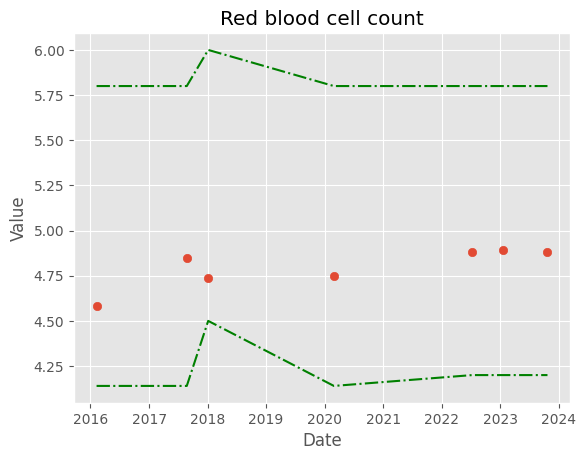

In [ ]:
analyte_name = 'red blood cell count' # @param ['albumin', 'red blood cell count', 'glucose', 'ldl', 'hdl', 'white blood cell count', 'platelets', 'triglycerides', 'vitamin b12', 'hba1c', 'vitamin d', 'cholesterol', 'testosterone']
analyte = df[df['lab'] == analyte_name]
analyte = analyte.sort_values(by=['date'])
analyte['low_ref'] = pd.to_numeric(analyte['low_ref'], errors='coerce')
analyte['low_ref'] = analyte['low_ref'].fillna(method='ffill')
analyte['high_ref'] = pd.to_numeric(analyte['high_ref'], errors='coerce')
analyte['high_ref'] = analyte['high_ref'].fillna(method='ffill')
plt.scatter(analyte['date'], analyte['value'])
plt.plot(analyte['date'], analyte['low_ref'], '-.', color='green')
plt.plot(analyte['date'], analyte['high_ref'], '-.', color='green')
plt.title(analyte_name.capitalize())
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Parse Fitbit Data

In [ ]:
latest_fitbit_path = find_latest_path(_FITBIT_ROOT_)

if latest_fitbit_path is None:
  print("No Fitbit data found")

latest_fitbit_path = os.path.join(latest_fitbit_path, 'Fitbit')

In [ ]:
import glob

all_csv_files = []
for folder in os.listdir(latest_fitbit_path):
  folder_path = os.path.join(latest_fitbit_path, folder)
  if os.path.isdir(folder_path):
    print(f"Processing folder: {folder_path}")
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    all_csv_files.extend(csv_files)
  else:
    print(f"{folder_path} is not a directory")


Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Account Changes
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Fitbit Care or Programs
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Messages
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Discover
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Heart Rate
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Stress Score
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Biometrics
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Fitbit Premium
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Menstrual Health
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Fitbit Friends
Processing folder: /content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Activity Goal

In [ ]:
all_csv_files

['/content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Account Changes/Account_Management_Events_1.csv',
 '/content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Messages/COACH Conversations_6bd161f0-eb1b-11ea-bade-871.csv',
 '/content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Discover/Coach Content Recommendations.csv',
 '/content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Heart Rate/Heart Rate Notifications Alerts.csv',
 '/content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Heart Rate/Heart Rate Notifications Profile.csv',
 '/content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Stress Score/Stress Score.csv',
 '/content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Biometrics/Glucose Target Ranges.csv',
 '/content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Fitbit Premium/User Premium Transactions.csv',
 '/content/drive/My Drive/Health Data/Fitbit/Takeout/Fitbit/Fitbit Premium/User Premium Subscriptions.csv',
 '/content/drive/My Drive/Health Data

In [ ]:
def process_fitbit_data(file_path: str) -> pd.DataFrame:
  category_mapping ={
      "Daily Readiness Score": "Readiness",
      "sleep_score": "Sleep",
      "Daily SpO2": "SpO2",
      "Respiratory Rate Summary": "Respiration",
      "Daily Respiratory Rate Summary": "Respiration",
      "Daily Heart Rate Variability Summary": "HRV",
      "Computed Temperature": "Stress",
      "Stress Score": "Stress"
  }